# Plot data

In [168]:
# Load data:
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
data_train=pd.read_excel("DST_BIL54_train.xlsx",header=None)
list_of_drive = data_train.iloc[1].values


In [169]:
# Create new column with time variable:
list_of_drive = list_of_drive[1:]

time = np.array([0+1/12 * i for i in range(0, len(list_of_drive))])

Text(0, 0.5, 'Drivmidler i alt')

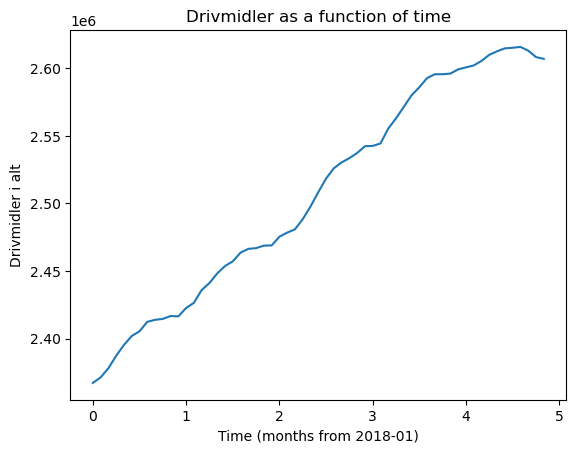

In [170]:

plt.plot(time,list_of_drive)
plt.title('Drivmidler as a function of time')
plt.xlabel('Time (months from 2018-01)')
plt.ylabel('Drivmidler i alt')

Notes
- Seems to be globally increasing somewhat linearly, stagnates towards the end and seems to be a slight harmonic structure 

# OLS

In [171]:
# calculate the parameters of an OLS regression:

# stack  with a columnn of ones:
data = np.array(list_of_drive)
time_inter = np.vstack((np.ones(len(time)), time.T)).T

# Calculate the parameters:
beta = np.linalg.inv(time_inter.T @ time_inter) @ time_inter.T @ data

In [172]:
beta

array([2373513.374576275, 55437.78305084715], dtype=object)

In [173]:
# estimate the errors of the parameters:

# calculate the residuals:
residuals = data - time_inter @ beta

# calculate the variance of the residuals:
variance = residuals.T @ residuals / (len(time) - 2)

# calculate the variance of the parameters:
var_beta = variance * np.linalg.inv(time_inter.T @ time_inter)

# calculate the standard deviation of the parameters:
std_beta = np.sqrt(np.diag(var_beta))

std_beta

array([2665.39728746,  951.06871284])

In [174]:
# forecaset of the drivmidler 
x_forecase = np.array([np.max(time)+1/12*i for i in range (1, 13)])
x_forecase = np.vstack((np.ones(len(x_forecase)), x_forecase.T)).T
y_forecase = x_forecase @ beta

# calculate the confidence interval:
t = stats.t.ppf(0.90, len(time) - 2)

# calculate the vmatrix based on variance and the x_forecase matrix:
vmatrix = variance * (1+x_forecase @ np.linalg.inv(time_inter.T @ time_inter) @ x_forecase.T)
y_forecase_upper = y_forecase + t * np.sqrt(np.diag(vmatrix))
y_forecase_lower = y_forecase - t * np.sqrt(np.diag(vmatrix))


In [176]:
# load the test data:

data_test=pd.read_excel("DST_BIL54_test.xlsx",header=None)
data_test = data_test.iloc[1].values
data_test = data_test[1:]

In [177]:
x_values = np.asarray(x_forecase[:, 1], dtype=float)
y_forecast = np.asarray(y_forecase, dtype=float)
y_forecast_lower = np.asarray(y_forecase_lower, dtype=float)
y_forecast_upper = np.asarray(y_forecase_upper, dtype=float)

TypeError: fill_between() missing 2 required positional arguments: 'x' and 'y1'

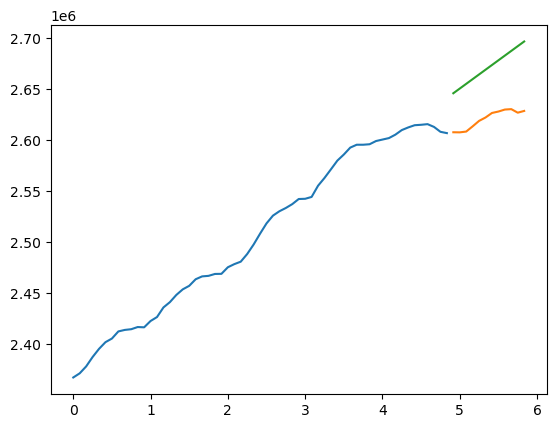

In [184]:
# plot the forecast data with the old data:
plt.plot(time,list_of_drive)
plt.plot(x_values,data_test)
plt.plot(x_values,y_forase)
plt.fill_between([1,2],1+ color='gray', alpha=0.5)
plt.legend(["Train data",'Test data','Forecast','Confidence interval'])
plt.xlabel('Time (Years from 2018-01)')
plt.ylabel('Drivmidler i alt')
plt.title('Drivmidler as a function of time')


[2631865.4517045375 2636449.638986701 2641033.0668127607 2645615.739208691
 2650197.6602931656 2654778.8342745164 2659359.2654476683
 2663938.9581910563 2668517.916963521 2673096.1463011946 2677673.650814379
 2682250.4351844233]
